In [13]:
import pandas as pd
import numpy as np
file_path = "Nat_Gas.csv"
df = pd.read_csv(file_path)
df["Dates"] = pd.to_datetime(df['Dates'], format = '%m/%d/%y')
df.head()
df['Year'] = df['Dates'].dt.year
df['Month'] = df['Dates'].dt.month
df['Day'] = df['Dates'].dt.day
df['lag_1'] = df['Prices'].shift(1)
df['lag_2'] = df['Prices'].shift(2)
df['lag_12'] = df['Prices'].shift(12)  # one-year lag

df['rolling_3'] = df['Prices'].rolling(window=3).mean().shift(1)
df['rolling_6'] = df['Prices'].rolling(window=6).mean().shift(1)
df['rolling_12'] = df['Prices'].rolling(window=12).mean().shift(1)
df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)


<Axes: xlabel='Dates', ylabel='Prices'>

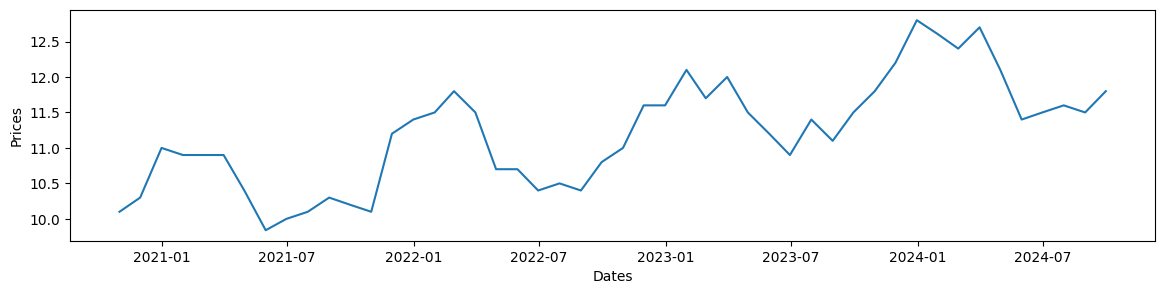

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(14,3))
sns.lineplot(x = 'Dates', y = 'Prices', data = df)

In [15]:
features = df[['Year','Month','Day','lag_1','lag_2','lag_12', 'rolling_3', 'rolling_6', 'rolling_12', 'month_sin', 'month_cos']]
X = features
y = df.Prices

from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

tscv = TimeSeriesSplit(n_splits = 4)
mae_scores = []

for train_idx, valid_idx in tscv.split(X):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    
    

    my_model = XGBRegressor(n_estimators = 500, learning_rate = 0.05, max_depth =3, subsample = 0.8, colsample_bytree = 0.8, random_state = 0)
    my_model.fit(X_train, y_train,
                eval_set= [(X_valid, y_valid)],
                early_stopping_rounds = 50,
                verbose = False)
                
    

    predictions = my_model.predict(X_valid)
    mae = mean_absolute_error(predictions, y_valid)
    mae_scores.append(mae)

mae_scores




/Users/rezapirbhai/Desktop/jpmc forage /.venv/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/rezapirbhai/Desktop/jpmc forage /.venv/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/rezapirbhai/Desktop/jpmc forage /.venv/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/rezapirbhai/Desktop/jpmc forage /.venv/lib/python3.10/site-packages/xgboost/sklearn.py:835: UserWarning: `early

[0.7759952121310764,
 0.5511016209920245,
 0.2566838370429145,
 0.14642874399820943]

In [16]:
#find one year after most recent data point
last_date = df['Dates'].max()
future_dates = pd.date_range(start = last_date  + pd.DateOffset(months=1), periods = 12, freq = 'M')

future_preds = []
last_known = df.copy()

for date in future_dates:

    recent = [float(x[0]) if isinstance(x, (np.ndarray, list)) else float(x)
              for x in last_known['Prices'].tail(12)]
    
    new_row = {
        'Year': date.year,
        'Month': date.month,
        'Day' : date.day,
        'lag_1': recent[-1],
        'lag_2': recent[-2] if len(recent) >= 2 else recent [-1],
        'lag_12' : recent[0] if len(recent) >= 12 else recent [-1],# one-year lag
        'rolling_3': np.mean(recent[-3:]),
        'rolling_6' : np.mean(recent[-6:]),
        'rolling_12' : np.mean(recent[-12:]),
        
        'month_sin' : np.sin(2 * np.pi * date.month / 12),
        'month_cos' : np.cos(2 * np.pi * date.month / 12)
        
 }



    X_future = pd.DataFrame([new_row])
 
    X_future = X_future.astype(float)

    pred_price = my_model.predict(X_future)
    future_preds.append((date, pred_price))

    last_known = pd.concat([
        last_known, 
        pd.DataFrame({'Dates':[date], 'Prices':[pred_price]})
    ])



/var/folders/cr/5nwsh8711fs8v6254rwrv4300000gn/T/ipykernel_7153/1304526079.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start = last_date  + pd.DateOffset(months=1), periods = 12, freq = 'M')


/var/folders/cr/5nwsh8711fs8v6254rwrv4300000gn/T/ipykernel_7153/1160729252.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  future_df['Prices'] = future_df['Prices'].apply(lambda x: float(x[0]) if isinstance(x, list) else float(x))


<Axes: xlabel='Dates', ylabel='Prices'>

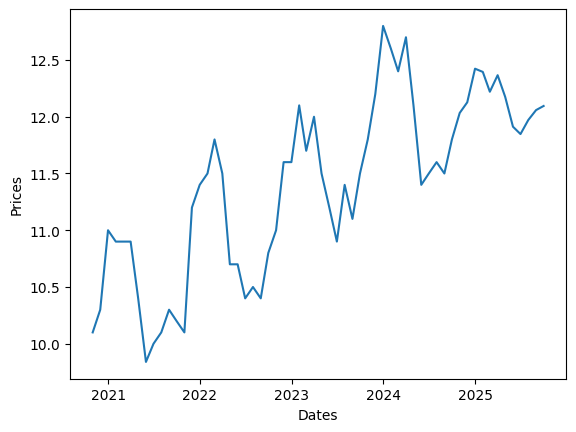

In [17]:
future_df = pd.DataFrame(future_preds, columns = ['Dates', 'Prices'])
future_df['Prices'] = future_df['Prices'].apply(lambda x: float(x[0]) if isinstance(x, list) else float(x))


combined = pd.concat([df[['Dates', 'Prices']], future_df], ignore_index = True)
combined.set_index('Dates', inplace = True)

sns.lineplot(x = 'Dates', y = 'Prices', data = combined)


In [18]:
def estimate_price(date_input):
    if isinstance(date_input, str):
        date_input = pd.to_datetime(date_input)
    
    if date_input in combined.index:
        return round(combined.loc[date_input, 'Prices'], 3)
    
    earlier = combined.index[combined.index < date_input].max()
    later = combined.index[combined.index > date_input].min()

    if pd.isna(earlier) or pd.isna(later):
        return f"No data available for {date_input}"
    
    p1 = combined.loc[earlier, 'Prices']
    p2 = combined.loc[later, 'Prices']

    delta_days = (later - earlier).days
    weight = (date_input - earlier).days / delta_days
    interpolated = p1 + weight * (p2-p1)
    flt_interpolated = float(interpolated)

    return round(flt_interpolated, 3)    


In [19]:
estimate_price('2023-2-02')

12.071

In [20]:


# Example list of dates
full_dates = pd.date_range(start='2020-10-31', end='2025-09-30')

# Apply your function
values = [estimate_price(date) for date in full_dates]

# Turn into DataFrame
full_df = pd.DataFrame({
    'Date': full_dates,
    'Prices': values
})

full_df.set_index('Date', inplace=True)


full_df


,Prices
Date,
2020-10-31,10.100
2020-11-01,10.107
2020-11-02,10.113
2020-11-03,10.120
2020-11-04,10.127
...,...
2025-09-26,12.090
2025-09-27,12.091
2025-09-28,12.092


In [21]:
from pandas import date_range

def price_storage_contract(
    injection_dates,
    withdrawal_dates,
    injection_rate,
    withdrawal_rate,
    max_volume,
    storage_cost_per_day):
    
    oil_cost = 0
    oil_revenue = 0
    current_inventory = 0
    oil_storage_cost = 0
    
    #Can only buy at injection rate if the max_vol - current_storage is suitable. SO WE HAVE TO SoRT BY DATE 
    #when i buy, I need to check the storage available and buy to the max of this and withdrawal 
    #then every day i need to calculate the total cost of storage at the current inv
    #then if i sell, this storage cost goes down.
    
    
    
    date_range = pd.date_range(
        start = min(injection_dates + withdrawal_dates),
        end = max(injection_dates + withdrawal_dates), 
        freq = 'D'
    )
    
    injection_dates = pd.to_datetime(injection_dates)
    withdrawal_dates = pd.to_datetime(withdrawal_dates)



    for date in date_range:
        
        oil_storage_cost += current_inventory * storage_cost_per_day
        
        if date in injection_dates:
            injection_price = float(full_df.loc[date, 'Prices'])
            max_injection = min(injection_rate, max_volume - current_inventory)
            oil_cost += (injection_price * max_injection)
            current_inventory += max_injection
        
        if date in withdrawal_dates and current_inventory > 0:
            withdrawal_price = float(full_df.loc[date, 'Prices'])
            max_withdrawal = min(withdrawal_rate, current_inventory)
            oil_revenue += (withdrawal_price * max_withdrawal)
            current_inventory -= max_withdrawal
            
            
        
            

    

    return oil_revenue - oil_storage_cost - oil_cost
        
        




In [22]:
price_storage_contract(['2022-05-30', '2022-07-30'], ['2022-12-31', '2023-01-30'], 10, 10, 100, 0.001)



20.879999999999995

In [23]:
import sys
print(sys.executable)


/Users/rezapirbhai/Desktop/jpmc forage /.venv/bin/python
